In [1]:
import cv2
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap
from AppKit import NSPasteboard, NSPasteboardTypePNG
from PIL import Image
import io

In [2]:
def plot_paving(paving, title=None):
	n = len(paving)
	fig, ax = plt.subplots(figsize=(n, n))
	ax.set_xticks(np.arange(0, n))
	ax.set_yticks(np.arange(0, n))
	ax.set_xticks(np.arange(-.5, n, 1), minor=True)
	ax.set_yticks(np.arange(-.5, n, 1), minor=True)
	# use a colormap that have a very different color for each value
	cm = plt.get_cmap("tab20_r")
	im = ax.imshow(paving, aspect="auto", cmap=cm, origin="lower")
	ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
	# delete axis
	ax.set_xticks([])
	ax.set_yticks([])
	# reverse the y axis
	ax.invert_yaxis()
	if title:
		ax.set_title(title)
	fig.tight_layout()
	plt.show()

In [25]:
def plot_solution(paving, solution, colors):
	normalized_colors = [(r / 255, g / 255, b / 255) for b, g, r in colors]
	cmap = ListedColormap(normalized_colors)

	n = len(paving)
	fig, ax = plt.subplots(figsize=(5, 5))
	ax.set_xticks(np.arange(0, n))
	ax.set_yticks(np.arange(0, n))
	ax.set_xticks(np.arange(-.5, n, 1), minor=True)
	ax.set_yticks(np.arange(-.5, n, 1), minor=True)
	
	im = ax.imshow(paving, aspect="auto", cmap=cmap, origin="lower")
	
	ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
	
	ax.set_xticks([])
	ax.set_yticks([])
	ax.invert_yaxis()
	
	queen_img = mpimg.imread("queen.png")  # Load the queen image
	for row, col in enumerate(solution):  # solution[row] gives the column for the queen in that row
		imagebox = OffsetImage(queen_img, zoom=0.035)  # Adjust zoom if needed
		ab = AnnotationBbox(imagebox, (col, row), frameon=False)  # Position at (col, row)
		ax.add_artist(ab)
	
	fig.tight_layout()
	plt.show()

In [26]:
def solution_valid_for_paving(paving, solution):
	queens_color = [paving[queen_x, queen_y] for queen_x, queen_y in enumerate(solution)]
	if len(set(queens_color)) != len(queens_color):
		return False
	return True

In [27]:
def solve(n, paving):
	try:
		with open(f'solution_{n}.txt', 'r') as f:
			solutions = [[int(x) for x in line.strip().split(',')] for line in f]
	except FileNotFoundError:
		print(f"Solutions for {n}x{n} not found")
		return 0
	nb_solutions = 0
	solutions_queen = []
	for solution in solutions:
		if solution_valid_for_paving(paving, solution):
			nb_solutions += 1
			solutions_queen.append(solution)
	if nb_solutions == 0:
		print(f"No valid solution found for {n}x{n}")
		return 0
	print(f"Found {nb_solutions} valid solutions for {n}x{n}")
	return solutions_queen

In [28]:
def load_image_from_clipboard():
	pb = NSPasteboard.generalPasteboard()
	data = pb.dataForType_(NSPasteboardTypePNG)
	if not data:
		print("No image found in clipboard.")
		return None
	image_data = data.bytes()
	byte_array = bytearray(image_data)
	image = Image.open(io.BytesIO(byte_array))
	opencv_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
	return opencv_image

In [29]:
def detect_grid(filename=None):
	if filename is None:
		image = load_image_from_clipboard()
		if image is None:
			return None
	else:
		image = cv2.imread(filename)
	gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	blurred = cv2.GaussianBlur(gray, (5, 5), 0)
	edges = cv2.Canny(blurred, 50, 150)

	contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

	contours = sorted(contours, key=cv2.contourArea, reverse=True)


	grid_contour = contours[0]
	x, y, w, h = cv2.boundingRect(grid_contour)

	grid = image[y:y+h, x:x+w]
	return grid

In [30]:
def is_duplicate(square1, square2, tolerance=10):
	x1, y1, w1, h1 = square1
	x2, y2, w2, h2 = square2

	return (
		abs(x1 - x2) <= tolerance and
		abs(y1 - y2) <= tolerance and
		abs(w1 - w2) <= tolerance and
		abs(h1 - h2) <= tolerance
	)

In [31]:
def align_squares(squares, tolerance=10):
	x_coords = [x for x, _, _, _ in squares]
	y_coords = [y for _, y, _, _ in squares]

	unique_x = np.unique([np.median([x for x in x_coords if abs(x - ref_x) <= tolerance]) for ref_x in x_coords])
	unique_y = np.unique([np.median([y for y in y_coords if abs(y - ref_y) <= tolerance]) for ref_y in y_coords])

	aligned_squares = []
	for x, y, w, h in squares:
		# Snap x and y to the nearest unique value
		closest_x = min(unique_x, key=lambda ref_x: abs(x - ref_x))
		closest_y = min(unique_y, key=lambda ref_y: abs(y - ref_y))
		aligned_squares.append((int(closest_x), int(closest_y), w, h))

	return aligned_squares

In [38]:
def extract_cells(grid):
	gray = cv2.cvtColor(grid, cv2.COLOR_BGR2GRAY)
	blurred = cv2.GaussianBlur(gray, (5, 5), 0)
	_, binary = cv2.threshold(blurred, 150, 255, cv2.THRESH_BINARY_INV)
	contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

	# find all squares in the image
	squares = []
	for contour in contours:
		epsilon = 0.05 * cv2.arcLength(contour, True)
		approx = cv2.approxPolyDP(contour, epsilon, True)

		if len(approx) == 4 and cv2.contourArea(approx) > 100:
			x, y, w, h = cv2.boundingRect(approx)
			aspect_ratio = float(w) / h
			if 0.9 <= aspect_ratio <= 1.1:  # Square aspect ratio
				squares.append((x, y, w, h))

	print(f"Found {len(squares)} squares")
	# Filter squares based on area
	if len(squares) > 0:
		areas = [w * h for _, _, w, h in squares]
		median_area = np.median(areas)

		area_tolerance = 0.2
		filtered_squares = [
			(x, y, w, h)
			for (x, y, w, h) in squares
			if abs(w * h - median_area) / median_area <= area_tolerance
		]
		squares = filtered_squares

	print(f"Filtered to {len(squares)} squares")
	# Filter squares based on similarity
	filtered_squares = []
	for square in squares:
		duplicate_found = False
		for filtered_square in filtered_squares:
			if is_duplicate(square, filtered_square):
				duplicate_found = True
				break
		if not duplicate_found:
			filtered_squares.append(square)

	print(f"Filtered to {len(filtered_squares)} squares")
	squares = filtered_squares
	squares = align_squares(squares)
	return squares


In [39]:
def extract_colors(grid, squares):
	squares = sorted(squares, key=lambda sq: (sq[1], sq[0]))
	color_map = defaultdict(list)
	colors_detected = []

	for square_idx, (x, y, w, h) in enumerate(squares):
		margin = 0.4
		x_center_start = int(x + margin * w)
		x_center_end = int(x + (1 - margin) * w)
		y_center_start = int(y + margin * h)
		y_center_end = int(y + (1 - margin) * h)

		center_region = grid[y_center_start:y_center_end, x_center_start:x_center_end]

		avg_color = cv2.mean(center_region)[:3]
		matched = False
		for idx, ref_color in enumerate(colors_detected):
			if np.linalg.norm(np.array(avg_color) - np.array(ref_color)) < 10:
				color_map[idx].append((square_idx, (x, y, w, h)))
				matched = True
				break
		if not matched:
			colors_detected.append(avg_color)
			color_map[len(colors_detected) - 1].append((square_idx, (x, y, w, h)))
	return color_map, colors_detected

In [40]:
# grid_image = grid.copy()
# for (x, y, w, h) in cells:
# 	cv2.rectangle(grid_image, (x, y), (x+w, y+h), (0, 255, 0), 2)
# cv2.imwrite('grid_with_cells.png', grid_image)

In [41]:
filename = 'board4.png'
grid_image = detect_grid(filename)
cv2.imwrite('extracted_grid.png', grid_image)

cells = extract_cells(grid_image)

print(f"Detected {len(cells)} cells")
assert len(cells) == int(np.sqrt(len(cells))) ** 2

n = int(np.sqrt(len(cells)))
print(f"Detected {n}x{n} grid")

color_map, colors_detected = extract_colors(grid_image, cells)
print(f"Detected {len(color_map)} colors")

print(colors_detected)

assert len(color_map) == n

# grid_image_with_colors = grid_image.copy()
# color_labels = ['Color ' + str(i + 1) for i in range(len(color_map))]
# for idx, squares_group in color_map.items():
# 	for square_idx, (x, y, w, h) in squares_group:
# 		cv2.rectangle(grid_image_with_colors, (x, y), (x+w, y+h), (0, 255, 0), 2)
# 		cv2.putText(grid_image_with_colors, f"{square_idx}, {color_labels[idx]}", (x+5, y+h//2), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
# cv2.imwrite('grid_with_colors.png', grid_image_with_colors)


grid = np.zeros((n, n), dtype=int)
for idx, squares_group in color_map.items():
	for square_idx, (x, y, w, h) in squares_group:
		grid[square_idx // n, square_idx % n] = idx

solutions = solve(n, grid)
plot_solution(grid, solutions[0], colors_detected)

Found 61 squares
Filtered to 60 squares
Filtered to 60 squares
Detected 60 cells


AssertionError: 

Found 65 squares
Filtered to 64 squares
Filtered to 64 squares
Detected 64 cells
Found 1 valid solutions for 8x8


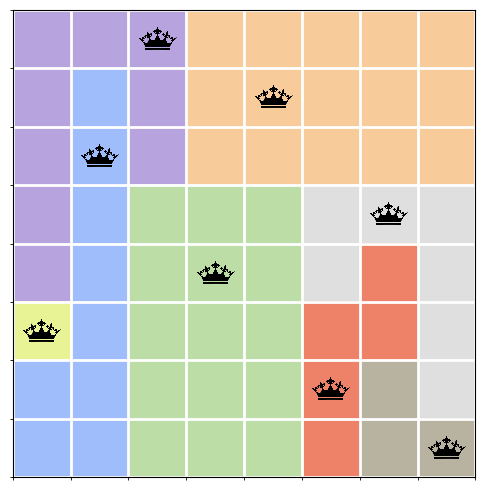

In [44]:
grid_image = detect_grid()
assert grid_image is not None
cells = extract_cells(grid_image)
print(f"Detected {len(cells)} cells")
assert len(cells) == int(np.sqrt(len(cells))) ** 2
n = int(np.sqrt(len(cells)))
color_map, colors_detected = extract_colors(grid_image, cells)
assert len(color_map) == n

grid = np.zeros((n, n), dtype=int)
for idx, squares_group in color_map.items():
	for square_idx, (x, y, w, h) in squares_group:
		grid[square_idx // n, square_idx % n] = idx

solutions = solve(n, grid)
for solution in solutions:
	plot_solution(grid, solution, colors_detected)
